In [1]:
# import nltk
import pandas as pd
from glob import glob
import gensim.downloader as api
from nltk.tokenize import TweetTokenizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wordninja
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tokenizer = TweetTokenizer()
glove_model = api.load("glove-twitter-25")
files = glob("lending_club_data/*.zip")

In [3]:
def read_one(path):
    return pd.read_csv(path, low_memory=False, skiprows=1, compression="zip")


def create_combined_dataset(files):

    data = [read_one(f"{file}") for file in files if file.endswith(".zip")]
    return pd.concat(data)


def build_dataset():

    features = [
        "title",
        "emp_title",
        "loan_status",
    ]
    df = create_combined_dataset(files)

    status_list = ["Fully Paid", "Charged Off", "Late (31-120 days)", "Default"]

    df = df[df["loan_status"].isin(status_list)]

    df["loan_status"] = df["loan_status"].apply(make_target)

    print(df.head())
    return df[features]


def make_target(val):
    return int(val in ["Charged Off", "Late (31-120 days)", "Default"])

In [4]:
df = build_dataset()

           id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
7   164193225        NaN     7500.0       7500.0           7500.0   36 months   
37  163162710        NaN    16000.0      16000.0          16000.0   36 months   
44  164066980        NaN    15000.0      15000.0          15000.0   36 months   
45  164190449        NaN    15000.0      15000.0          15000.0   60 months   
55  164173227        NaN    10500.0      10500.0          10500.0   36 months   

   int_rate  installment grade sub_grade  ...  \
7    12.40%       250.55     B        B4  ...   
37    6.46%       490.10     A        A1  ...   
44   11.02%       491.23     B        B2  ...   
45   23.05%       423.29     D        D3  ...   
55   25.65%       421.10     D        D4  ...   

   orig_projected_additional_accrued_interest hardship_payoff_balance_amount  \
7                                         NaN                            NaN   
37                                        NaN             

In [5]:
df["emp_title"].value_counts()

Teacher                  32981
Manager                  29743
Owner                    17435
Registered Nurse         13494
RN                       12861
                         ...  
Braum's Inc                  1
Area HSE Manager             1
Mario Magcalas               1
somerset ridge center        1
reseption                    1
Name: emp_title, Length: 472663, dtype: int64

In [6]:
df[df["title"].str.lower() == "re.split(r'\W+', 'Words, words, words.')"]

,title,emp_title,loan_status


In [7]:
mask = [isinstance(item, (str, bytes)) for item in df["title"]]
df = df.loc[mask]
mask = [isinstance(item, (str, bytes)) for item in df["emp_title"]]
df = df.loc[mask]

# words = [get_words(col) for col in ["title","emp_title",]]

In [8]:
SINGLES = {"other", "vacation", "business", "consolidate"}


def get_vectors(input_string):
    """Get the sum of the word vectors... Also, try to clean up some stuff"""
    # Empty array
    final_vector = np.zeros(25)
    # Tokenize the words in the input
    words = tokenizer.tokenize(input_string)
    # If there's only one word, something went wrong with the tokenizer
    if len(words) == 1 and words[0].lower() not in SINGLES:
        # Try to split without spaces
        words = re.split(r"[\W_]+", words[0])
        # print(words)
        if len(words) == 1:
            # print("split")
            words = wordninja.split(words[0])

    # Check for spelling errors
    # misspelled = spell.unknown(words)
    # For the words we've found
    for word in words:
        # If the word is misspelled
        # if word in misspelled:
        #     print(f"Fixing {word}")
        #     # Correct it
        #     word = spell.correction(word)
        try:
            # Add the vector from glove to the final_vector
            final_vector += glove_model.word_vec(word.lower())
        except KeyError:
            # print(f"{word.lower()} not valid")
            pass
    # print(f"Added {len(words)}")
    return final_vector

In [9]:
df["title_vectors"] = df["title"].apply(lambda x: get_vectors(x))
df["emp_title_vectors"] = df["emp_title"].apply(lambda x: get_vectors(x))

In [14]:
df_new = pd.DataFrame(
    df["title_vectors"].to_list(), columns=[f"{i}_title_vector" for i in range(25)]
)
df_new["loan_status"] = df["loan_status"].reset_index(drop=True)
df_new = df_new.sample(n=5000)
# print(df_new)

# pca = PCA(n_components=4)
# pca_result = pca.fit_transform(df_new.drop("loan_status",axis=1).values)
# df_new["pca-one"] = pca_result[:, 0]
# df_new["pca-two"] = pca_result[:, 1]
# df_new['pca-three'] = pca_result[:,2]
# df_new['pca-four'] = pca_result[:,3]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, n_jobs=8)
tsne_results = tsne.fit_transform(df_new.drop("loan_status",axis=1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.813026
[t-SNE] KL divergence after 1000 iterations: 1.424067


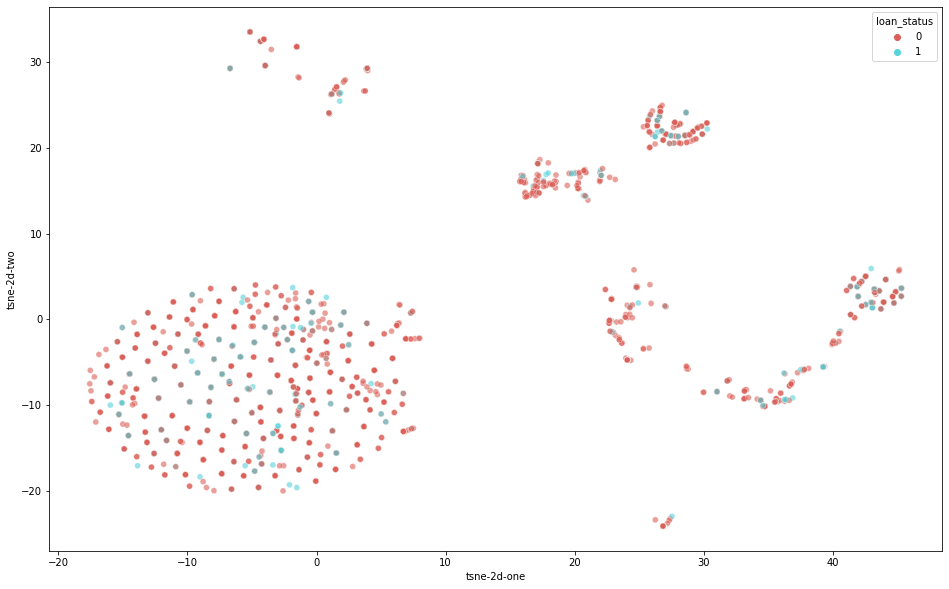

In [15]:
df_new['tsne-2d-one'] = tsne_results[:,0]
df_new['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="loan_status",
    palette=sns.color_palette("hls", 2),
    data=df_new,
    legend="full",
    alpha=0.6,
)